<a href="https://colab.research.google.com/github/Sungrebe/Smart-Bird-Feeder/blob/main/cc_backyard_bird_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# install astrapy and sentence_transformers (run this every time the runtime restarts)
!pip install astrapy
!pip install transformers

import os
from PIL import Image
from matplotlib import pyplot as plt
from astrapy import DataAPIClient
from transformers import CLIPProcessor, CLIPModel
from google.colab import drive, userdata, files

# load database and image collection

client = DataAPIClient(userdata.get('ASTRA_DB_APPLICATION_TOKEN'))
db = client.get_database(userdata.get('ASTRA_DB_API_ENDPOINT'))
col = db.get_collection("cc_backyard_birds")

# load CLIP model (Vit-B-32)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Helper method for the model to process image inputs
def process_image(image_path):
  input = processor(
    images=Image.open(image_path),
    return_tensors="pt"
  )
  return model.get_image_features(**input).flatten()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Hash table with select bird species (only 11 for testing purposes)
# and their image folders from the nabirds dataset
# in the final version we will have at least 100 species
species = {
    "Mourning Dove": ["0529"],
    "Red-bellied Woodpecker": ["0553"],
    "Blue Jay": ["0950"],
    "Black-capped Chickadee": ["0812"],
    "Tufted Titmouse": ["0819"],
    "European Starling": ["0748", "0856", "1005"],
    "American Robin": ["0753", "0960"],
    "House Finch": ["0790", "0997"],
    "American Goldfinch": ["0794", "1001"],
    "Common Grackle": ["0912"],
    "Northern Cardinal": ["0772", "0979"],
}

"""
# load cc_backyard_birds images into dataset

drive.mount('/content/drive')
nabirds_dir = "/content/drive/MyDrive/nabirds/"

for species_name, species_folders in species.items():
  for folder in species_folders:
    for img_file in os.listdir(nabirds_dir + folder):
      # convert each image into a vector representation using CLIP model
      img_vector = process_image(nabirds_dir + folder + "/" + img_file)

      col.insert_one({
          "text": species_name,
          "$vector": img_vector.tolist(),
      })
"""

'\n# load cc_backyard_birds images into dataset\n\ndrive.mount(\'/content/drive\')\nnabirds_dir = "/content/drive/MyDrive/nabirds/"\n\nfor species_name, species_folders in species.items():\n  for folder in species_folders:\n    for img_file in os.listdir(nabirds_dir + folder):\n      # convert each image into a vector representation using CLIP model\n      img_vector = process_image(nabirds_dir + folder + "/" + img_file)\n\n      col.insert_one({\n          "text": species_name,\n          "$vector": img_vector.tolist(),\n      })\n'

In [1]:
# TODO: implement fine-tuning algorithm
import random
import os
import re
import torch
import torch.nn.functional as F

# We will use triplet loss

# Basic idea is that for each species, we create a set of triplets
# Each triplet consists of three images - an anchor, positive, and negative
# The anchor image is an image of the species, the positive another
# image of that species, and the negative an image of an unrelated but
# easily confused species (from the perspective of the model)

# 1. Create a dataset of triplets (~10 for each species to start with)
# For each triplet, it will be saved in the following order:
# the name of the bird species, then the image ID of the anchor
# the image ID of the positive, and the image ID of the negative

nabirds_dir = "/content/drive/MyDrive/nabirds/"

species = {
    "Mourning Dove": ["0529"],
    "Red-bellied Woodpecker": ["0553"],
    "Blue Jay": ["0950"],
    "Black-capped Chickadee": ["0812"],
    "Tufted Titmouse": ["0819"],
    "European Starling": ["0748", "0856", "1005"],
    "American Robin": ["0753", "0960"],
    "House Finch": ["0790", "0997"],
    "American Goldfinch": ["0794", "1001"],
    "Common Grackle": ["0912"],
    "Northern Cardinal": ["0772", "0979"],
}

async def search_img(image_path):
  searching_vector = process_image(image_path).tolist()
  most_similar_imgs = col.find(
      {},
      sort={"$vector": searching_vector},
      limit=30,
      include_similarity=True,
  )

  return most_similar_imgs

def process_image(image_path):
  input = processor(
    images=Image.open(image_path),
    return_tensors="pt"
  )
  return model.get_image_features(**input).flatten()

async def create_triplets():
  triplets_array = []
  for species_name, species_folders in species.items():
    for folder in species_folders:
      # Randomly select 10 pictures to use as anchors
      selected_items = random.sample(os.listdir(nabirds_dir + folder), 10)
      fpaths = []
      for img_file in selected_items:
        fpaths.append(nabirds_dir + folder + "/" + img_file)
      # Create a triplet using each anchor
      for path in fpaths:
        results = await search_img(path)
        # Search for positive
        positive_id = ''
        results_list = list(results)
        for result in reversed(results_list):
          if result['text'] == species_name:
            positive_id = result['_id']
            break
        # Search for negative
        negative_id = ''
        for result in results_list:
          if result['text'] != species_name:
            negative_id = result['_id']
            break

        match = re.search(r'/(\d{4})/(\w+)(?=\.(jpg|png))', path)
        if match:
            alphanumeric_address = match.group(1) + '/' + match.group(2)
        triplets_array.append([species_name, alphanumeric_address, positive_id, negative_id])

  return triplets_array

triplets = await create_triplets()
print(triplets)



# 2. Split dataset into training, test, and validation
async def split_dataset(triplets):
  training_triplets = []
  test_triplets = []
  validation_triplets = []
  i = 0
  for triplet in triplets:
    if (i % 10 < 8):
      training_triplets.append(triplet)
    elif (i % 10 == 8):
      test_triplets.append(triplet)
    else:
      validation_triplets.append(triplet)
    i += 1
  return training_triplets, test_triplets, validation_triplets

training_triplets, test_triplets, validation_triplets = await split_dataset(triplets)


# 3. Define triplet loss function
# Torch import at the top

def triplet_loss(anchor, positive, negative, margin=1.0):
    """
    Compute the triplet loss according to the formula:
    Loss = max(d(A, P) - d(A, N) + margin, 0)

    Parameters:
    - anchor: address for anchor, needs to be converted to tensor of shape (batch_size, embedding_dim) for the anchor examples
    - positive: address for positive, needs to be converted to tensor of shape (batch_size, embedding_dim) for the positive examples
    - negative: address for negative, needs to be converted to tensor of shape (batch_size, embedding_dim) for the negative examples
    - margin: Float, the margin for triplet loss

    Returns:
    - loss: Scalar, the computed triplet loss
    """
    anchor_tensor = process_image(nabirds_dir + "/" + anchor)
    positive_tensor = process_image(nabirds_dir + "/" + positive)
    negative_tensor = process_image(nabirds_dir + "/" + negative)
    # Compute the pairwise distances
    pos_distance = F.pairwise_distance(anchor_tensor, positive_tensor, p=2)
    neg_distance = F.pairwise_distance(anchor_tensor, negative_tensor, p=2)

    # Compute the triplet loss
    loss = torch.clamp(pos_distance - neg_distance + margin, min=0.0)

    # Return the mean loss over the batch
    return loss.mean()

for triplet in training_triplets:
  print(triplet)
  print(triplet_loss(triplet[1], triplet[2], triplet[3]))


# 4. Write a training loop
  # - Compute predicted outputs
  # - Get loss for each step
  # - Perform optimization
  # - Get val accuracy after each step

# 5. Save a copy of the fine tuned model

# 6. Create a new collection of images using the fine tuned model and
# perform image searches using that collection

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/nabirds/0529'

Saving 550843841.jpg to 550843841 (10).jpg


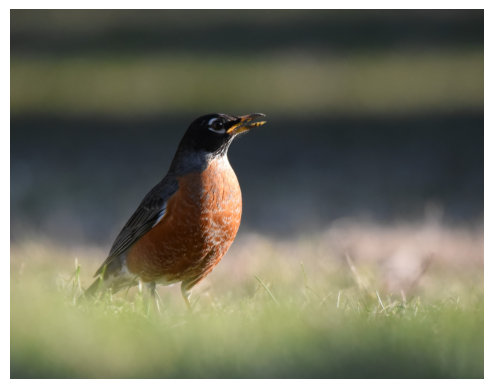

DataAPIResponseException: Collection does not exist, collection name: cc_backyard_birds

In [16]:
# method for searching database
# returns top 15 most similar images given a specific image
from google.colab import drive, userdata, files

async def search_img(image_path):
  searching_vector = process_image(image_path).tolist()
  most_similar_imgs = col.find(
      {},
      sort={"$vector": searching_vector},
      limit=30,
      include_similarity=True,
  )

  return most_similar_imgs

# demo code, loads a user inputted image and classifies it using the search_img method

images = files.upload()
input_path = next(iter(images))

plt.imshow(Image.open(input_path))
plt.axis("off")
plt.show()

results = await search_img(input_path)

print(list(results.limit(1)))
# for result in results:
#   #if (result.get('$text') == 'American Robin'):
#   print(result)
#   print(result['text'])